Using CNNs to Predict the Output of Chemical Simulation under Uncertainty

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import norm
from tqdm import tqdm
from base import TrainingConfig, BaseModel, CNNConfig, CNNConfig
from models import *
from Bioprocess_Sim import *
from CSTR_Sim import *
from utils import *
from tqdm.notebook import tqdm
np.random.seed(42)

#### Create the Simulation Environment - for a CSTR

3 State Variables:
$$
C_A, \, T, \, \text{Concentration of A, Temperature and Setpoint}, C_{As}
$$

2 Manipulated Variables:
$$
T_i, \, C_{Af} \, \text{Inlet Temperature and Feed Concentration}
$$

Disturbance: 
$$
T_C, \text{ - coolant temperature}
$$

The Simulation randomly generates actions, setpoints and disturbances across the length of the simulation, with the aim of the data driven model being to learn the relationships between variables to predict the temporal value of the state variables (exc setpoint) within a confidence interval

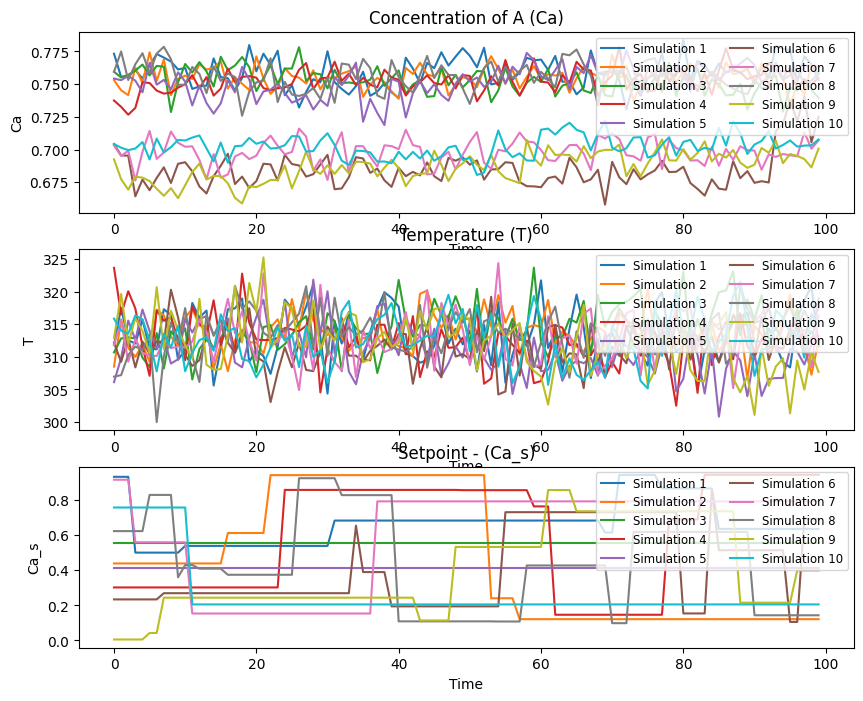

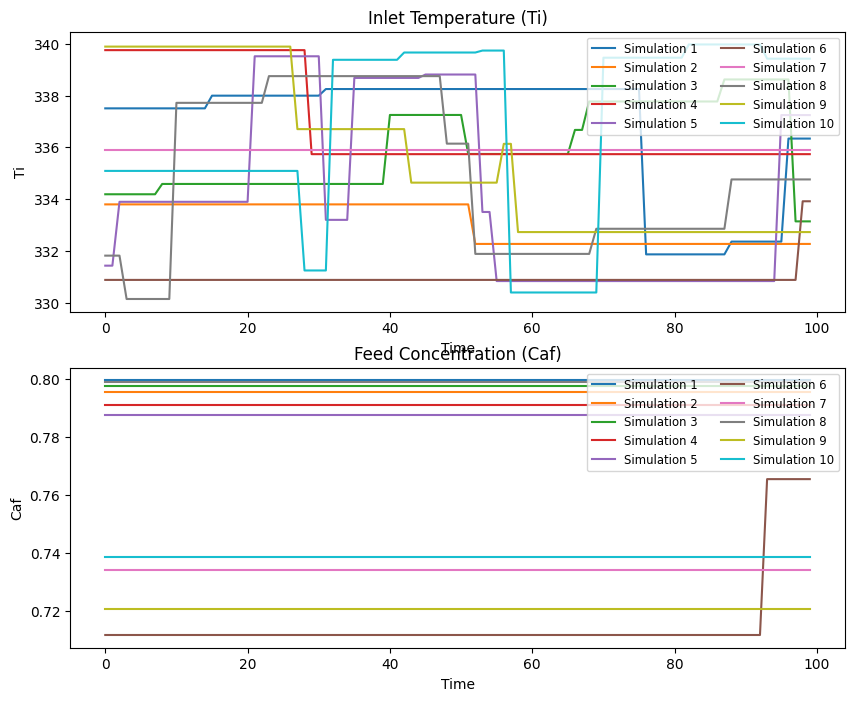

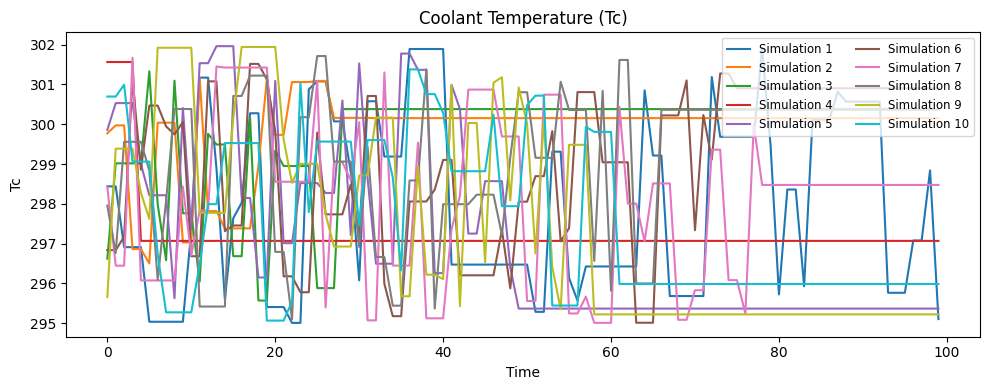

In [2]:
CSTR_Config = SimulationConfig(n_simulations=10, T = 101, tsim = 500) # Simulate the CSTR 10 times, with 5000 timesteps over 1000 second period

simulator = CSTRSimulator(CSTR_Config)
simulation_results = simulator.run_multiple_simulations()

# Plot the output of the Simulation
simulator.plot_results(simulation_results)

Then process the simulation output into data to be fed into the data driven model. First define a training configuration.

The data is processed into sequences with a lookback window and a prediction horizon of shape (time_step, lookback_window, no_features).

The data is then scaled using a MinMaxScaler, and split into a sequential train test set with the first 80% of the datapoints being included in the train set.


In [3]:
converter = CSTRConverter()
features, targets = converter.convert(simulation_results)

# Define a preliminary training configuration for the model
# Data processing uses an initial lookback region of 5 timesteps to predict 1 in the future 
# with an 80% train test split and a batch size of 4
training_config = TrainingConfig(
    batch_size = 4,
    num_epochs = 50,
    learning_rate = 0.001,
    time_step = 5,
    horizon = 1,
    weight_decay = 0.01,
    factor = 0.8,
    patience = 10,
    delta = 0.1,
    train_test_split = 0.8,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
)

data_processor = DataProcessor(training_config)
(train_loader, test_loader, X_train, X_test, y_train, y_test) = data_processor.prepare_data(features, targets)

Can then train an initial model, in this example use a unidirectional point prediction CNN, defining the configuration for the model.

In [4]:
CNN_Config = CNNConfig(
    conv_channels = [16, 32],
    kernel_sizes = [5, 3],
    fc_dims = [101, 128],
    dropout = 0.1
    )

model = StandardCNN(
    config = CNN_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: 0.0406, Test Loss: 0.0426, Avg Loss: 0.0416
Epoch [20/50], Train Loss: 0.0391, Test Loss: 0.0406, Avg Loss: 0.0398
Epoch [30/50], Train Loss: 0.0390, Test Loss: 0.0405, Avg Loss: 0.0398
Epoch [40/50], Train Loss: 0.0386, Test Loss: 0.0416, Avg Loss: 0.0401
Epoch [50/50], Train Loss: 0.0393, Test Loss: 0.0414, Avg Loss: 0.0404


Evaluate the model and inverse transform the data to plot and visualise the model predictions against the ground truth.

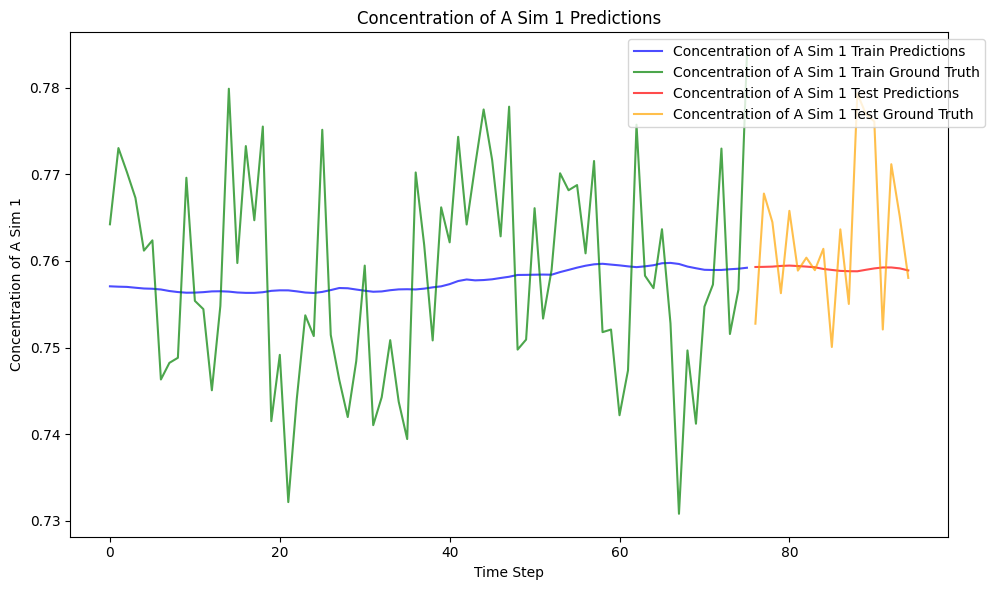

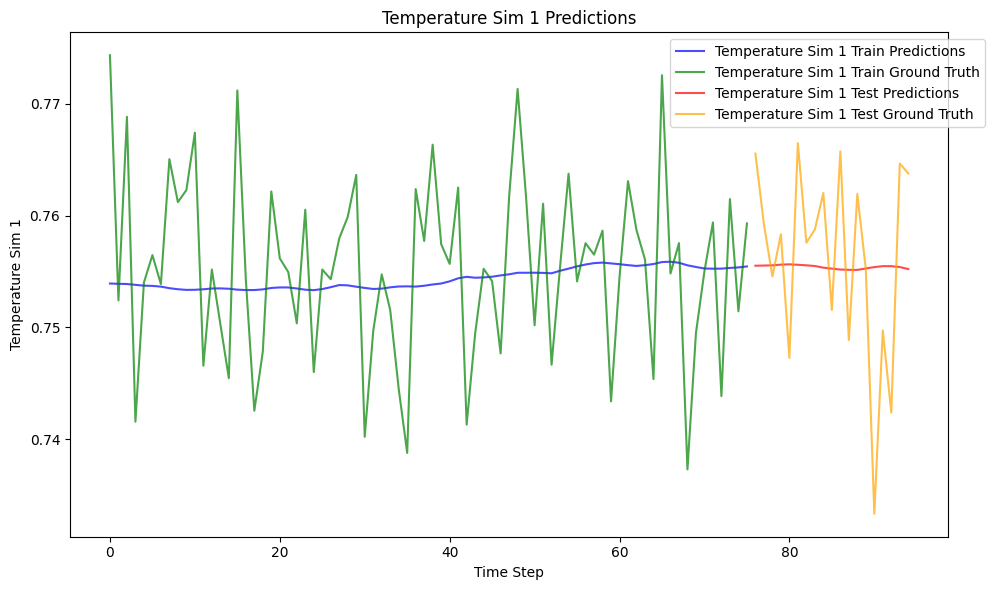

In [5]:
# Find the model predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Transform the predictions back to the original
scaler = data_processor.target_scaler
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Invert the ground truth data
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
# For simplicity we will plot the first simulation
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=1)
    

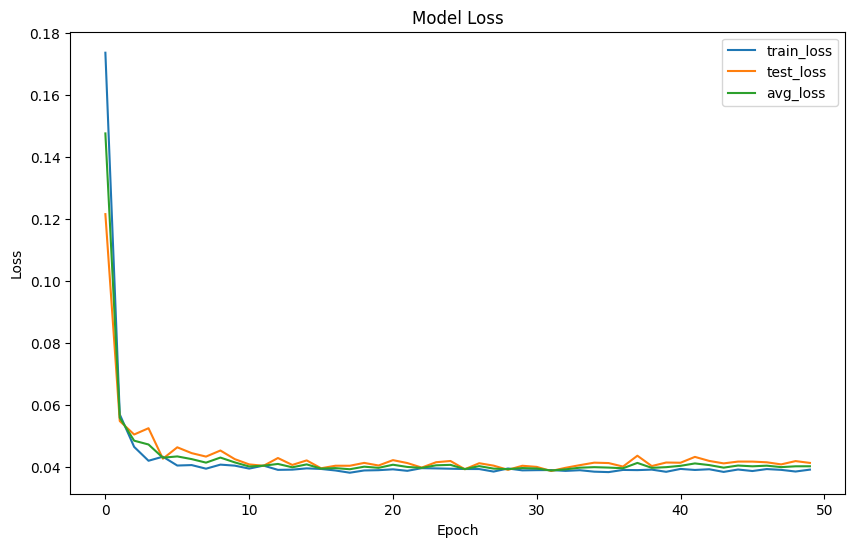

In [6]:
# Plot the loss of the model
visualiser.plot_loss(history)

We can also calculate the complexity of the model using the number of FLOPs

In [23]:
import fvcore
from fvcore.nn import FlopCountAnalysis

flops = FlopCountAnalysis(model, X_train.to(training_config.device))
print(f"Number of FLOPs: {flops.total()}")
print(f"Number of Model Params: {sum(p.numel() for p in model.parameters())}")

Unsupported operator aten::adaptive_avg_pool1d encountered 1 time(s)


Number of FLOPs: 614240
Number of Model Params: 33679


Can use Bayesian Optimisation to find the best hyperparameters for the model

In [7]:
# First set the bounds for CNN Model
CNN_ConfigBounds = {
# Training config bounds
'batch_size': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
'num_epochs': (50, 500),
'learning_rate': (0.0001, 0.1),
'time_step': (2, 50) if isinstance(simulator, CSTRSimulator) else (2, 10),
'horizon': (1, 10),
'weight_decay': (1e-6, 0.1),
'factor': (0.1, 0.99),
'patience': (5, 100),
'delta': (1e-6, 0.1),      

# CNN specific bounds - much wider ranges
'conv_channels': [(8, 128), (16, 256)],  # Much wider range for channel sizes
'kernel_sizes': [(2, 9), (2, 7)],       # More kernel size options
'fc_dims': [(32, 512), (64, 1024)],     # Wider range for fully connected layers
'dropout': (0.0, 0.9)                    # Full range of dropout values
}

# Call the optimiser
optimiser = ModelOptimisation(model_class=StandardCNN, sim_config=CSTR_Config,
                              train_config=training_config, model_config=CNN_Config,
                              config_bounds=CNN_ConfigBounds, simulator=CSTRSimulator,
                              converter=CSTRConverter, data_processor=DataProcessor,
                              trainer_class=ModelTrainer, iters=20)

best_params, best_loss = optimiser.optimise()
# The best performing model is saved automatically by the optimiser and can be loaded
cp = torch.load('best_model.pth')
model = StandardCNN(cp['model_config'],
                     input_dim=X_train.shape[2],
                     output_dim=y_train.shape[1],
                     )
model.load_state_dict(cp['model_state_dict'])

Epoch [10/228], Train Loss: 0.0508, Test Loss: 0.0547, Avg Loss: 0.0527
Epoch [20/228], Train Loss: 0.0718, Test Loss: 0.0770, Avg Loss: 0.0744
Epoch [30/228], Train Loss: 0.0784, Test Loss: 0.0814, Avg Loss: 0.0799
Epoch [40/228], Train Loss: 0.0777, Test Loss: 0.0799, Avg Loss: 0.0788
Epoch [50/228], Train Loss: 0.0763, Test Loss: 0.0837, Avg Loss: 0.0800
Epoch [60/228], Train Loss: 0.0812, Test Loss: 0.0829, Avg Loss: 0.0821
Epoch [70/228], Train Loss: 0.0751, Test Loss: 0.0780, Avg Loss: 0.0766
Epoch [80/228], Train Loss: 0.0866, Test Loss: 0.0903, Avg Loss: 0.0884
Epoch [90/228], Train Loss: 0.0815, Test Loss: 0.0879, Avg Loss: 0.0847
Epoch [100/228], Train Loss: 0.0782, Test Loss: 0.0825, Avg Loss: 0.0804
Epoch [110/228], Train Loss: 0.0807, Test Loss: 0.0806, Avg Loss: 0.0806
Epoch [120/228], Train Loss: 0.0796, Test Loss: 0.0811, Avg Loss: 0.0804
Epoch [130/228], Train Loss: 0.0813, Test Loss: 0.0817, Avg Loss: 0.0815
Epoch [140/228], Train Loss: 0.0848, Test Loss: 0.0859, Avg 

Optimisation Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/355], Train Loss: 0.0670, Test Loss: 0.0747, Avg Loss: 0.0708
Epoch [20/355], Train Loss: 0.0723, Test Loss: 0.0616, Avg Loss: 0.0670
Epoch [30/355], Train Loss: 0.0721, Test Loss: 0.0734, Avg Loss: 0.0728
Epoch [40/355], Train Loss: 0.0713, Test Loss: 0.0656, Avg Loss: 0.0685
Epoch [50/355], Train Loss: 0.0709, Test Loss: 0.0685, Avg Loss: 0.0697
Epoch [60/355], Train Loss: 0.0743, Test Loss: 0.0595, Avg Loss: 0.0669
Epoch [70/355], Train Loss: 0.0649, Test Loss: 0.0610, Avg Loss: 0.0629
Epoch [80/355], Train Loss: 0.0601, Test Loss: 0.0570, Avg Loss: 0.0585
Epoch [90/355], Train Loss: 0.0631, Test Loss: 0.0596, Avg Loss: 0.0613
Epoch [100/355], Train Loss: 0.0612, Test Loss: 0.0611, Avg Loss: 0.0612
Epoch [110/355], Train Loss: 0.0638, Test Loss: 0.0594, Avg Loss: 0.0616
Epoch [120/355], Train Loss: 0.0619, Test Loss: 0.0586, Avg Loss: 0.0602
Epoch [130/355], Train Loss: 0.0632, Test Loss: 0.0576, Avg Loss: 0.0604
Epoch [140/355], Train Loss: 0.0583, Test Loss: 0.0605, Avg 

Optimisation Progress:   5%|▌         | 1/20 [00:13<04:14, 13.38s/it, Loss=0.0583]

Epoch [350/355], Train Loss: 0.0586, Test Loss: 0.0580, Avg Loss: 0.0583
Epoch [10/141], Train Loss: 3.6696, Test Loss: 1.9125, Avg Loss: 2.7910
Epoch [20/141], Train Loss: 0.1585, Test Loss: 0.1424, Avg Loss: 0.1504
Epoch [30/141], Train Loss: 0.0820, Test Loss: 0.0815, Avg Loss: 0.0818
Epoch [40/141], Train Loss: 0.0751, Test Loss: 0.0823, Avg Loss: 0.0787
Epoch [50/141], Train Loss: 0.0757, Test Loss: 0.0837, Avg Loss: 0.0797
Epoch [60/141], Train Loss: 0.0771, Test Loss: 0.0976, Avg Loss: 0.0873
Epoch [70/141], Train Loss: 0.0771, Test Loss: 0.0778, Avg Loss: 0.0775
Epoch [80/141], Train Loss: 0.0679, Test Loss: 0.0747, Avg Loss: 0.0713
Epoch [90/141], Train Loss: 0.0681, Test Loss: 0.0694, Avg Loss: 0.0688
Epoch [100/141], Train Loss: 0.0653, Test Loss: 0.0729, Avg Loss: 0.0691
Epoch [110/141], Train Loss: 0.0630, Test Loss: 0.0716, Avg Loss: 0.0673
Epoch [120/141], Train Loss: 0.0645, Test Loss: 0.0696, Avg Loss: 0.0670
Epoch [130/141], Train Loss: 0.0673, Test Loss: 0.0676, Avg 

Optimisation Progress:  10%|█         | 2/20 [00:17<02:19,  7.75s/it, Loss=0.0583]

Epoch [140/141], Train Loss: 0.0636, Test Loss: 0.0694, Avg Loss: 0.0665
Epoch [10/439], Train Loss: 0.0644, Test Loss: 0.1134, Avg Loss: 0.0889
Epoch [20/439], Train Loss: 0.0475, Test Loss: 0.0991, Avg Loss: 0.0733
Epoch [30/439], Train Loss: 0.0470, Test Loss: 0.0883, Avg Loss: 0.0677
Epoch [40/439], Train Loss: 0.0506, Test Loss: 0.0960, Avg Loss: 0.0733
Epoch [50/439], Train Loss: 0.0492, Test Loss: 0.0958, Avg Loss: 0.0725
Epoch [60/439], Train Loss: 0.0513, Test Loss: 0.0369, Avg Loss: 0.0441
Epoch [70/439], Train Loss: 0.0469, Test Loss: 0.0451, Avg Loss: 0.0460
Epoch [80/439], Train Loss: 0.0459, Test Loss: 0.3221, Avg Loss: 0.1840
Epoch [90/439], Train Loss: 0.0490, Test Loss: 0.0751, Avg Loss: 0.0621
Epoch [100/439], Train Loss: 0.0472, Test Loss: 0.0521, Avg Loss: 0.0497
Epoch [110/439], Train Loss: 0.0472, Test Loss: 0.0461, Avg Loss: 0.0466
Epoch [120/439], Train Loss: 0.0467, Test Loss: 0.0849, Avg Loss: 0.0658
Epoch [130/439], Train Loss: 0.0445, Test Loss: 0.0515, Avg 

Optimisation Progress:  15%|█▌        | 3/20 [00:22<01:50,  6.48s/it, Loss=0.0493]

Epoch [140/439], Train Loss: 0.0441, Test Loss: 0.0544, Avg Loss: 0.0493
Early Stopping
Epoch [10/447], Train Loss: 0.0477, Test Loss: 0.0365, Avg Loss: 0.0421
Epoch [20/447], Train Loss: 0.0574, Test Loss: 0.0405, Avg Loss: 0.0490
Epoch [30/447], Train Loss: 0.0499, Test Loss: 0.0390, Avg Loss: 0.0445
Epoch [40/447], Train Loss: 0.0515, Test Loss: 0.0444, Avg Loss: 0.0480
Epoch [50/447], Train Loss: 0.0512, Test Loss: 0.0368, Avg Loss: 0.0440
Epoch [60/447], Train Loss: 0.0492, Test Loss: 0.0431, Avg Loss: 0.0461
Epoch [70/447], Train Loss: 0.0527, Test Loss: 0.0403, Avg Loss: 0.0465
Epoch [80/447], Train Loss: 0.0484, Test Loss: 0.0397, Avg Loss: 0.0440
Epoch [90/447], Train Loss: 0.0494, Test Loss: 0.0392, Avg Loss: 0.0443
Epoch [100/447], Train Loss: 0.0506, Test Loss: 0.0386, Avg Loss: 0.0446
Epoch [110/447], Train Loss: 0.0480, Test Loss: 0.0381, Avg Loss: 0.0430
Epoch [120/447], Train Loss: 0.0510, Test Loss: 0.0396, Avg Loss: 0.0453
Epoch [130/447], Train Loss: 0.0485, Test Los

Optimisation Progress:  20%|██        | 4/20 [00:26<01:30,  5.67s/it, Loss=0.044] 

Epoch [10/122], Train Loss: 0.0751, Test Loss: 0.0504, Avg Loss: 0.0627
Epoch [20/122], Train Loss: 0.0616, Test Loss: 0.0631, Avg Loss: 0.0623
Epoch [30/122], Train Loss: 0.0451, Test Loss: 0.0560, Avg Loss: 0.0506
Epoch [40/122], Train Loss: 0.0448, Test Loss: 0.0500, Avg Loss: 0.0474
Epoch [50/122], Train Loss: 0.0371, Test Loss: 0.0521, Avg Loss: 0.0446
Epoch [60/122], Train Loss: 0.0393, Test Loss: 0.0470, Avg Loss: 0.0432
Epoch [70/122], Train Loss: 0.0387, Test Loss: 0.0497, Avg Loss: 0.0442
Epoch [80/122], Train Loss: 0.0368, Test Loss: 0.0510, Avg Loss: 0.0439
Epoch [90/122], Train Loss: 0.0375, Test Loss: 0.0513, Avg Loss: 0.0444
Epoch [100/122], Train Loss: 0.0364, Test Loss: 0.0465, Avg Loss: 0.0415
Epoch [110/122], Train Loss: 0.0321, Test Loss: 0.0478, Avg Loss: 0.0399


Optimisation Progress:  25%|██▌       | 5/20 [00:29<01:12,  4.85s/it, Loss=0.0411]

Epoch [120/122], Train Loss: 0.0386, Test Loss: 0.0461, Avg Loss: 0.0424
Epoch [10/357], Train Loss: 0.0880, Test Loss: 0.0848, Avg Loss: 0.0864
Epoch [20/357], Train Loss: 0.0866, Test Loss: 0.0779, Avg Loss: 0.0822
Epoch [30/357], Train Loss: 0.0849, Test Loss: 0.0772, Avg Loss: 0.0811
Epoch [40/357], Train Loss: 0.0904, Test Loss: 0.0802, Avg Loss: 0.0853
Epoch [50/357], Train Loss: 0.0921, Test Loss: 0.0800, Avg Loss: 0.0860
Epoch [60/357], Train Loss: 0.0828, Test Loss: 0.0775, Avg Loss: 0.0802
Epoch [70/357], Train Loss: 0.0836, Test Loss: 0.0770, Avg Loss: 0.0803
Epoch [80/357], Train Loss: 0.0911, Test Loss: 0.0798, Avg Loss: 0.0854
Epoch [90/357], Train Loss: 0.0849, Test Loss: 0.0787, Avg Loss: 0.0818
Epoch [100/357], Train Loss: 0.0860, Test Loss: 0.0770, Avg Loss: 0.0815
Epoch [110/357], Train Loss: 0.0894, Test Loss: 0.0792, Avg Loss: 0.0843
Epoch [120/357], Train Loss: 0.0886, Test Loss: 0.0784, Avg Loss: 0.0835
Epoch [130/357], Train Loss: 0.0882, Test Loss: 0.0790, Avg 

Optimisation Progress:  30%|███       | 6/20 [00:38<01:26,  6.18s/it, Loss=0.0411]

Epoch [350/357], Train Loss: 0.0856, Test Loss: 0.0793, Avg Loss: 0.0825
Epoch [10/428], Train Loss: 0.0546, Test Loss: 0.0739, Avg Loss: 0.0642
Epoch [20/428], Train Loss: 0.0591, Test Loss: 0.0625, Avg Loss: 0.0608
Epoch [30/428], Train Loss: 0.0651, Test Loss: 0.0631, Avg Loss: 0.0641
Epoch [40/428], Train Loss: 0.0673, Test Loss: 0.0645, Avg Loss: 0.0659
Epoch [50/428], Train Loss: 0.0665, Test Loss: 0.0636, Avg Loss: 0.0651
Epoch [60/428], Train Loss: 0.0678, Test Loss: 0.0638, Avg Loss: 0.0658
Epoch [70/428], Train Loss: 0.0662, Test Loss: 0.0637, Avg Loss: 0.0650
Epoch [80/428], Train Loss: 0.0673, Test Loss: 0.0639, Avg Loss: 0.0656
Epoch [90/428], Train Loss: 0.0668, Test Loss: 0.0634, Avg Loss: 0.0651
Epoch [100/428], Train Loss: 0.0685, Test Loss: 0.0639, Avg Loss: 0.0662
Epoch [110/428], Train Loss: 0.0687, Test Loss: 0.0651, Avg Loss: 0.0669
Epoch [120/428], Train Loss: 0.0685, Test Loss: 0.0642, Avg Loss: 0.0664
Epoch [130/428], Train Loss: 0.0665, Test Loss: 0.0625, Avg 

Optimisation Progress:  35%|███▌      | 7/20 [00:55<02:05,  9.62s/it, Loss=0.0411]

Epoch [10/461], Train Loss: 5.2797, Test Loss: 8.7178, Avg Loss: 6.9988
Epoch [20/461], Train Loss: 4.1161, Test Loss: 0.1165, Avg Loss: 2.1163
Epoch [30/461], Train Loss: 0.2691, Test Loss: 0.0546, Avg Loss: 0.1619
Epoch [40/461], Train Loss: 0.0833, Test Loss: 0.0772, Avg Loss: 0.0803
Epoch [50/461], Train Loss: 0.0832, Test Loss: 0.0709, Avg Loss: 0.0771
Epoch [60/461], Train Loss: 0.0748, Test Loss: 0.0655, Avg Loss: 0.0701
Epoch [70/461], Train Loss: 0.0628, Test Loss: 0.0536, Avg Loss: 0.0582
Epoch [80/461], Train Loss: 0.0622, Test Loss: 0.0642, Avg Loss: 0.0632
Epoch [90/461], Train Loss: 0.0605, Test Loss: 0.0512, Avg Loss: 0.0559
Epoch [100/461], Train Loss: 0.1826, Test Loss: 0.0436, Avg Loss: 0.1131
Epoch [110/461], Train Loss: 0.0593, Test Loss: 0.0468, Avg Loss: 0.0531
Epoch [120/461], Train Loss: 0.0580, Test Loss: 0.0476, Avg Loss: 0.0528
Epoch [130/461], Train Loss: 0.0548, Test Loss: 0.0524, Avg Loss: 0.0536
Epoch [140/461], Train Loss: 0.0539, Test Loss: 0.0445, Avg 

Optimisation Progress:  40%|████      | 8/20 [01:09<02:13, 11.12s/it, Loss=0.0411]

Epoch [460/461], Train Loss: 0.0462, Test Loss: 0.0423, Avg Loss: 0.0442
Epoch [10/361], Train Loss: 0.0434, Test Loss: 0.0721, Avg Loss: 0.0578
Epoch [20/361], Train Loss: 0.0411, Test Loss: 0.0569, Avg Loss: 0.0490
Epoch [30/361], Train Loss: 0.0438, Test Loss: 0.0969, Avg Loss: 0.0703
Epoch [40/361], Train Loss: 0.0485, Test Loss: 0.0506, Avg Loss: 0.0495
Epoch [50/361], Train Loss: 0.0412, Test Loss: 0.0425, Avg Loss: 0.0419
Epoch [60/361], Train Loss: 0.0452, Test Loss: 0.0987, Avg Loss: 0.0719
Epoch [70/361], Train Loss: 0.0478, Test Loss: 0.0682, Avg Loss: 0.0580
Epoch [80/361], Train Loss: 0.0404, Test Loss: 0.0580, Avg Loss: 0.0492
Epoch [90/361], Train Loss: 0.0430, Test Loss: 0.0551, Avg Loss: 0.0491
Epoch [100/361], Train Loss: 0.0413, Test Loss: 0.0549, Avg Loss: 0.0481
Epoch [110/361], Train Loss: 0.0428, Test Loss: 0.0565, Avg Loss: 0.0497
Epoch [120/361], Train Loss: 0.0423, Test Loss: 0.0539, Avg Loss: 0.0481
Epoch [130/361], Train Loss: 0.0409, Test Loss: 0.0550, Avg 

Optimisation Progress:  45%|████▌     | 9/20 [01:16<01:46,  9.72s/it, Loss=0.0411]

Epoch [350/361], Train Loss: 0.0435, Test Loss: 0.0543, Avg Loss: 0.0489
Epoch [360/361], Train Loss: 0.0397, Test Loss: 0.0540, Avg Loss: 0.0469
Epoch [10/66], Train Loss: 0.0422, Test Loss: 0.1119, Avg Loss: 0.0771
Epoch [20/66], Train Loss: 0.0621, Test Loss: 0.0979, Avg Loss: 0.0800
Epoch [30/66], Train Loss: 0.0445, Test Loss: 0.0407, Avg Loss: 0.0426
Epoch [40/66], Train Loss: 0.0506, Test Loss: 0.0511, Avg Loss: 0.0508
Epoch [50/66], Train Loss: 0.0429, Test Loss: 0.1077, Avg Loss: 0.0753
Epoch [60/66], Train Loss: 0.0432, Test Loss: 0.0562, Avg Loss: 0.0497


Optimisation Progress:  50%|█████     | 10/20 [01:20<01:18,  7.84s/it, Loss=0.0411]

Epoch [10/422], Train Loss: 3.1670, Test Loss: 148.5072, Avg Loss: 75.8371
Epoch [20/422], Train Loss: 0.3967, Test Loss: 0.1654, Avg Loss: 0.2810
Epoch [30/422], Train Loss: 0.1049, Test Loss: 0.1086, Avg Loss: 0.1067
Epoch [40/422], Train Loss: 0.0910, Test Loss: 0.0867, Avg Loss: 0.0888
Epoch [50/422], Train Loss: 0.0707, Test Loss: 0.0846, Avg Loss: 0.0777
Epoch [60/422], Train Loss: 0.0606, Test Loss: 0.0784, Avg Loss: 0.0695
Epoch [70/422], Train Loss: 0.0544, Test Loss: 0.0833, Avg Loss: 0.0689
Epoch [80/422], Train Loss: 0.0514, Test Loss: 0.0768, Avg Loss: 0.0641
Epoch [90/422], Train Loss: 0.0460, Test Loss: 0.0753, Avg Loss: 0.0607
Epoch [100/422], Train Loss: 0.0471, Test Loss: 0.0790, Avg Loss: 0.0631
Epoch [110/422], Train Loss: 0.0479, Test Loss: 0.0740, Avg Loss: 0.0610
Epoch [120/422], Train Loss: 0.0461, Test Loss: 0.0760, Avg Loss: 0.0611
Epoch [130/422], Train Loss: 0.0442, Test Loss: 0.0744, Avg Loss: 0.0593
Epoch [140/422], Train Loss: 0.0466, Test Loss: 0.0740, A

Optimisation Progress:  55%|█████▌    | 11/20 [01:29<01:15,  8.41s/it, Loss=0.0411]

Epoch [420/422], Train Loss: 0.0422, Test Loss: 0.0751, Avg Loss: 0.0587
Epoch [10/134], Train Loss: 0.0994, Test Loss: 0.0399, Avg Loss: 0.0697
Epoch [20/134], Train Loss: 0.0401, Test Loss: 0.0342, Avg Loss: 0.0372
Epoch [30/134], Train Loss: 0.0378, Test Loss: 0.0341, Avg Loss: 0.0360
Epoch [40/134], Train Loss: 0.0397, Test Loss: 0.0333, Avg Loss: 0.0365
Epoch [50/134], Train Loss: 0.0373, Test Loss: 0.0349, Avg Loss: 0.0361
Epoch [60/134], Train Loss: 0.0376, Test Loss: 0.0334, Avg Loss: 0.0355
Epoch [70/134], Train Loss: 0.0380, Test Loss: 0.0350, Avg Loss: 0.0365
Epoch [80/134], Train Loss: 0.0368, Test Loss: 0.0350, Avg Loss: 0.0359
Epoch [90/134], Train Loss: 0.0384, Test Loss: 0.0340, Avg Loss: 0.0362
Epoch [100/134], Train Loss: 0.0392, Test Loss: 0.0356, Avg Loss: 0.0374
Epoch [110/134], Train Loss: 0.0366, Test Loss: 0.0348, Avg Loss: 0.0357


Optimisation Progress:  60%|██████    | 12/20 [01:31<00:51,  6.47s/it, Loss=0.0354]

Epoch [120/134], Train Loss: 0.0376, Test Loss: 0.0339, Avg Loss: 0.0358
Epoch [130/134], Train Loss: 0.0368, Test Loss: 0.0344, Avg Loss: 0.0356
Epoch [10/430], Train Loss: 0.0808, Test Loss: 0.0879, Avg Loss: 0.0844
Epoch [20/430], Train Loss: 0.0508, Test Loss: 0.0657, Avg Loss: 0.0583
Epoch [30/430], Train Loss: 0.0620, Test Loss: 0.0706, Avg Loss: 0.0663
Epoch [40/430], Train Loss: 0.0685, Test Loss: 0.0743, Avg Loss: 0.0714
Epoch [50/430], Train Loss: 0.0738, Test Loss: 0.0807, Avg Loss: 0.0773
Epoch [60/430], Train Loss: 0.0711, Test Loss: 0.0774, Avg Loss: 0.0742
Epoch [70/430], Train Loss: 0.0728, Test Loss: 0.0786, Avg Loss: 0.0757
Epoch [80/430], Train Loss: 0.0733, Test Loss: 0.0785, Avg Loss: 0.0759
Epoch [90/430], Train Loss: 0.0715, Test Loss: 0.0785, Avg Loss: 0.0750
Epoch [100/430], Train Loss: 0.0715, Test Loss: 0.0787, Avg Loss: 0.0751
Epoch [110/430], Train Loss: 0.0723, Test Loss: 0.0791, Avg Loss: 0.0757
Epoch [120/430], Train Loss: 0.0740, Test Loss: 0.0786, Avg 

Optimisation Progress:  65%|██████▌   | 13/20 [01:45<01:00,  8.68s/it, Loss=0.0354]

Epoch [410/430], Train Loss: 0.0682, Test Loss: 0.0787, Avg Loss: 0.0735
Early Stopping
Epoch [10/312], Train Loss: 0.3986, Test Loss: 0.3865, Avg Loss: 0.3925
Epoch [20/312], Train Loss: 0.1870, Test Loss: 0.3931, Avg Loss: 0.2901
Epoch [30/312], Train Loss: 0.0591, Test Loss: 0.0467, Avg Loss: 0.0529
Epoch [40/312], Train Loss: 0.0418, Test Loss: 0.0424, Avg Loss: 0.0421
Epoch [50/312], Train Loss: 0.0380, Test Loss: 0.0317, Avg Loss: 0.0348
Epoch [60/312], Train Loss: 0.0382, Test Loss: 0.0371, Avg Loss: 0.0376
Epoch [70/312], Train Loss: 0.0382, Test Loss: 0.0325, Avg Loss: 0.0354
Epoch [80/312], Train Loss: 0.0367, Test Loss: 0.0335, Avg Loss: 0.0351
Epoch [90/312], Train Loss: 0.0377, Test Loss: 0.0341, Avg Loss: 0.0359
Epoch [100/312], Train Loss: 0.0379, Test Loss: 0.0329, Avg Loss: 0.0354
Epoch [110/312], Train Loss: 0.0375, Test Loss: 0.0333, Avg Loss: 0.0354
Epoch [120/312], Train Loss: 0.0378, Test Loss: 0.0334, Avg Loss: 0.0356
Epoch [130/312], Train Loss: 0.0378, Test Los

Optimisation Progress:  70%|███████   | 14/20 [01:56<00:56,  9.47s/it, Loss=0.0354]

Epoch [310/312], Train Loss: 0.0366, Test Loss: 0.0356, Avg Loss: 0.0361
Epoch [10/371], Train Loss: 0.0489, Test Loss: 0.0609, Avg Loss: 0.0549
Epoch [20/371], Train Loss: 0.0541, Test Loss: 0.0542, Avg Loss: 0.0541
Epoch [30/371], Train Loss: 0.0446, Test Loss: 0.0648, Avg Loss: 0.0547
Epoch [40/371], Train Loss: 0.0455, Test Loss: 0.0550, Avg Loss: 0.0503
Epoch [50/371], Train Loss: 0.0432, Test Loss: 0.0539, Avg Loss: 0.0486
Epoch [60/371], Train Loss: 0.0415, Test Loss: 0.0550, Avg Loss: 0.0483
Epoch [70/371], Train Loss: 0.0420, Test Loss: 0.0561, Avg Loss: 0.0491
Epoch [80/371], Train Loss: 0.0410, Test Loss: 0.0582, Avg Loss: 0.0496
Epoch [90/371], Train Loss: 0.0417, Test Loss: 0.0585, Avg Loss: 0.0501
Epoch [100/371], Train Loss: 0.0420, Test Loss: 0.0592, Avg Loss: 0.0506
Epoch [110/371], Train Loss: 0.0425, Test Loss: 0.0573, Avg Loss: 0.0499
Epoch [120/371], Train Loss: 0.0411, Test Loss: 0.0569, Avg Loss: 0.0490
Epoch [130/371], Train Loss: 0.0406, Test Loss: 0.0592, Avg 

Optimisation Progress:  75%|███████▌  | 15/20 [02:07<00:48,  9.74s/it, Loss=0.0354]

Epoch [370/371], Train Loss: 0.0411, Test Loss: 0.0579, Avg Loss: 0.0495
Epoch [10/450], Train Loss: 0.0681, Test Loss: 0.0641, Avg Loss: 0.0661
Epoch [20/450], Train Loss: 0.0729, Test Loss: 0.0735, Avg Loss: 0.0732
Epoch [30/450], Train Loss: 0.0825, Test Loss: 0.0797, Avg Loss: 0.0811
Epoch [40/450], Train Loss: 0.0818, Test Loss: 0.0803, Avg Loss: 0.0811
Epoch [50/450], Train Loss: 0.0833, Test Loss: 0.0809, Avg Loss: 0.0821
Epoch [60/450], Train Loss: 0.0846, Test Loss: 0.0810, Avg Loss: 0.0828
Epoch [70/450], Train Loss: 0.0829, Test Loss: 0.0810, Avg Loss: 0.0819
Epoch [80/450], Train Loss: 0.0829, Test Loss: 0.0810, Avg Loss: 0.0819
Epoch [90/450], Train Loss: 0.0823, Test Loss: 0.0810, Avg Loss: 0.0816
Epoch [100/450], Train Loss: 0.0833, Test Loss: 0.0810, Avg Loss: 0.0821
Epoch [110/450], Train Loss: 0.0826, Test Loss: 0.0810, Avg Loss: 0.0818
Epoch [120/450], Train Loss: 0.0828, Test Loss: 0.0810, Avg Loss: 0.0819
Epoch [130/450], Train Loss: 0.0829, Test Loss: 0.0810, Avg 

Optimisation Progress:  80%|████████  | 16/20 [02:12<00:33,  8.37s/it, Loss=0.0354]

Epoch [140/450], Train Loss: 0.0839, Test Loss: 0.0810, Avg Loss: 0.0824
Early Stopping
Epoch [10/170], Train Loss: 28.4245, Test Loss: 217586.0000, Avg Loss: 108807.2123
Epoch [20/170], Train Loss: 0.1564, Test Loss: 0.0480, Avg Loss: 0.1022
Epoch [30/170], Train Loss: 0.1979, Test Loss: 0.1123, Avg Loss: 0.1551
Epoch [40/170], Train Loss: 0.1643, Test Loss: 0.0525, Avg Loss: 0.1084
Epoch [50/170], Train Loss: 0.1555, Test Loss: 0.5297, Avg Loss: 0.3426
Epoch [60/170], Train Loss: 0.0538, Test Loss: 0.0619, Avg Loss: 0.0578
Epoch [70/170], Train Loss: 0.0616, Test Loss: 0.3497, Avg Loss: 0.2056
Epoch [80/170], Train Loss: 0.0842, Test Loss: 0.0979, Avg Loss: 0.0910
Epoch [90/170], Train Loss: 0.0572, Test Loss: 0.2342, Avg Loss: 0.1457
Epoch [100/170], Train Loss: 0.0904, Test Loss: 0.1636, Avg Loss: 0.1270
Epoch [110/170], Train Loss: 0.0542, Test Loss: 1.8601, Avg Loss: 0.9571
Epoch [120/170], Train Loss: 0.0530, Test Loss: 0.1724, Avg Loss: 0.1127
Epoch [130/170], Train Loss: 0.056

Optimisation Progress:  85%|████████▌ | 17/20 [02:21<00:26,  8.68s/it, Loss=0.0354]

Epoch [170/170], Train Loss: 0.0469, Test Loss: 0.0580, Avg Loss: 0.0524
Epoch [10/402], Train Loss: 0.0915, Test Loss: 0.0537, Avg Loss: 0.0726
Epoch [20/402], Train Loss: 0.0461, Test Loss: 0.0505, Avg Loss: 0.0483
Epoch [30/402], Train Loss: 0.0490, Test Loss: 0.0497, Avg Loss: 0.0493
Epoch [40/402], Train Loss: 0.0480, Test Loss: 0.0515, Avg Loss: 0.0497
Epoch [50/402], Train Loss: 0.0506, Test Loss: 0.0515, Avg Loss: 0.0511
Epoch [60/402], Train Loss: 0.0492, Test Loss: 0.0508, Avg Loss: 0.0500
Epoch [70/402], Train Loss: 0.0507, Test Loss: 0.0526, Avg Loss: 0.0517
Epoch [80/402], Train Loss: 0.0486, Test Loss: 0.0530, Avg Loss: 0.0508
Epoch [90/402], Train Loss: 0.0499, Test Loss: 0.0513, Avg Loss: 0.0506
Epoch [100/402], Train Loss: 0.0492, Test Loss: 0.0532, Avg Loss: 0.0512
Epoch [110/402], Train Loss: 0.0491, Test Loss: 0.0536, Avg Loss: 0.0514
Epoch [120/402], Train Loss: 0.0496, Test Loss: 0.0526, Avg Loss: 0.0511
Epoch [130/402], Train Loss: 0.0507, Test Loss: 0.0526, Avg 

Optimisation Progress:  90%|█████████ | 18/20 [02:44<00:26, 13.01s/it, Loss=0.0354]

Epoch [400/402], Train Loss: 0.0520, Test Loss: 0.0517, Avg Loss: 0.0518
Epoch [10/120], Train Loss: 0.0509, Test Loss: 0.0439, Avg Loss: 0.0474
Epoch [20/120], Train Loss: 0.0479, Test Loss: 0.0431, Avg Loss: 0.0455
Epoch [30/120], Train Loss: 0.0472, Test Loss: 0.0451, Avg Loss: 0.0461
Epoch [40/120], Train Loss: 0.0486, Test Loss: 0.0437, Avg Loss: 0.0462
Epoch [50/120], Train Loss: 0.0457, Test Loss: 0.0445, Avg Loss: 0.0451
Epoch [60/120], Train Loss: 0.0480, Test Loss: 0.0441, Avg Loss: 0.0461
Epoch [70/120], Train Loss: 0.0492, Test Loss: 0.0442, Avg Loss: 0.0467
Epoch [80/120], Train Loss: 0.0480, Test Loss: 0.0443, Avg Loss: 0.0462
Epoch [90/120], Train Loss: 0.0476, Test Loss: 0.0443, Avg Loss: 0.0460
Epoch [100/120], Train Loss: 0.0477, Test Loss: 0.0443, Avg Loss: 0.0460
Epoch [110/120], Train Loss: 0.0481, Test Loss: 0.0443, Avg Loss: 0.0462
Epoch [120/120], Train Loss: 0.0481, Test Loss: 0.0443, Avg Loss: 0.0462


Optimisation Progress:  95%|█████████▌| 19/20 [02:49<00:10, 10.42s/it, Loss=0.0354]

Epoch [10/367], Train Loss: 0.0522, Test Loss: 0.0672, Avg Loss: 0.0597
Epoch [20/367], Train Loss: 0.0591, Test Loss: 0.0631, Avg Loss: 0.0611
Epoch [30/367], Train Loss: 0.0612, Test Loss: 0.0645, Avg Loss: 0.0629
Epoch [40/367], Train Loss: 0.0624, Test Loss: 0.0664, Avg Loss: 0.0644
Epoch [50/367], Train Loss: 0.0647, Test Loss: 0.0665, Avg Loss: 0.0656
Epoch [60/367], Train Loss: 0.0617, Test Loss: 0.0650, Avg Loss: 0.0633
Epoch [70/367], Train Loss: 0.0623, Test Loss: 0.0658, Avg Loss: 0.0640
Epoch [80/367], Train Loss: 0.0622, Test Loss: 0.0652, Avg Loss: 0.0637
Epoch [90/367], Train Loss: 0.0624, Test Loss: 0.0656, Avg Loss: 0.0640
Epoch [100/367], Train Loss: 0.0616, Test Loss: 0.0656, Avg Loss: 0.0636


Optimisation Progress: 100%|██████████| 20/20 [02:52<00:00,  8.61s/it, Loss=0.0354]

Epoch [110/367], Train Loss: 0.0621, Test Loss: 0.0656, Avg Loss: 0.0639
Early Stopping


<All keys matched successfully>

After optimising the model, load the data

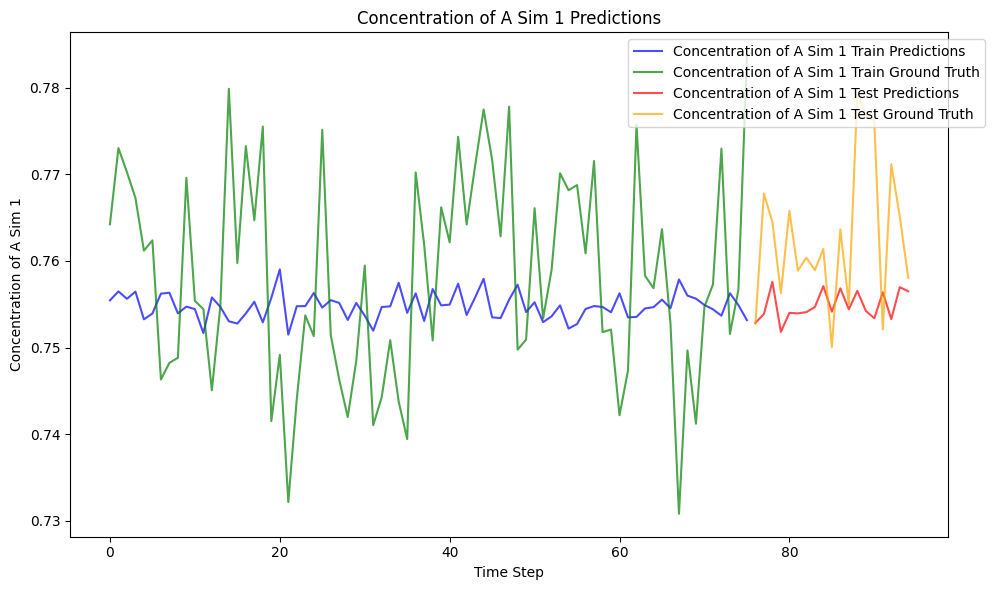

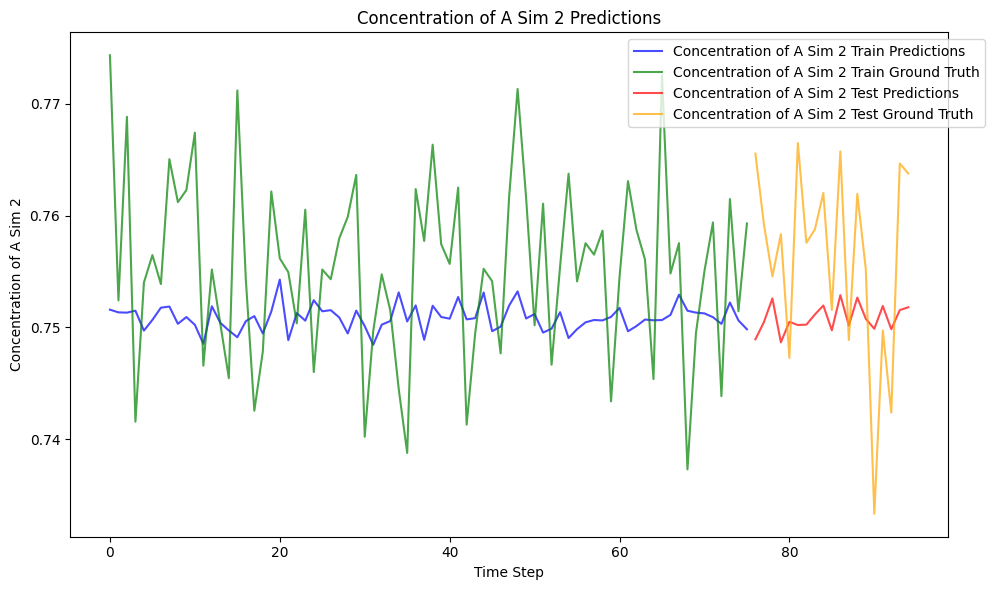

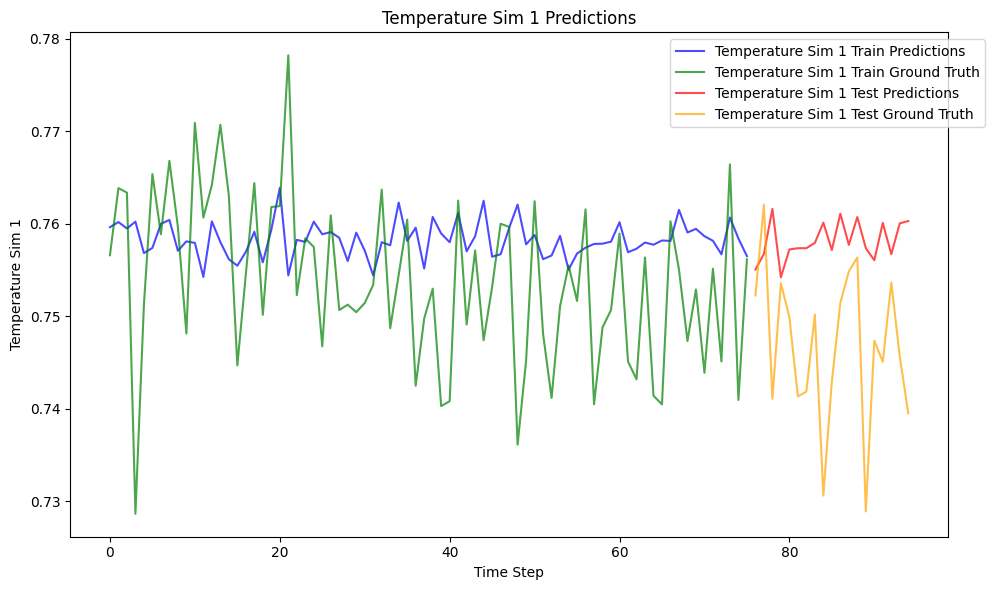

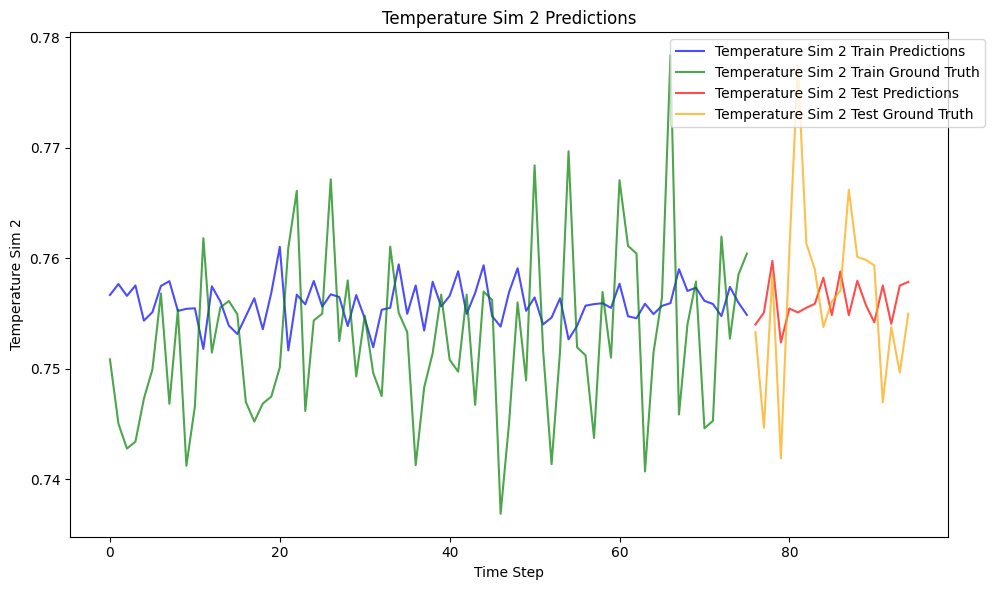

In [8]:
train_pred = model(X_train.to(training_config.device)).cpu().detach().numpy()
test_pred = model(X_test.to(training_config.device)).cpu().detach().numpy()

# Transform the predictions back to the original
train_pred, test_pred = scaler.inverse_transform(train_pred), scaler.inverse_transform(test_pred)
 
# Plot the optimised predictions of the model
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=2)

Can also use a second simulation, a Photoproduction Bioprocess Reactor.

This has state variables:
$C_x$ , biomass concentration in g/L

$C_N$ , nitrate concentration in mg/L

$C_{qc}$ , phycocyanin concentration in mg/L

The control variables are:
$I$, light intensity in $\mu  mol  m^{-2}  s^{-1}$

$F_N$, nitrate flow rate in $ mg. L^{-1} h{-1} $

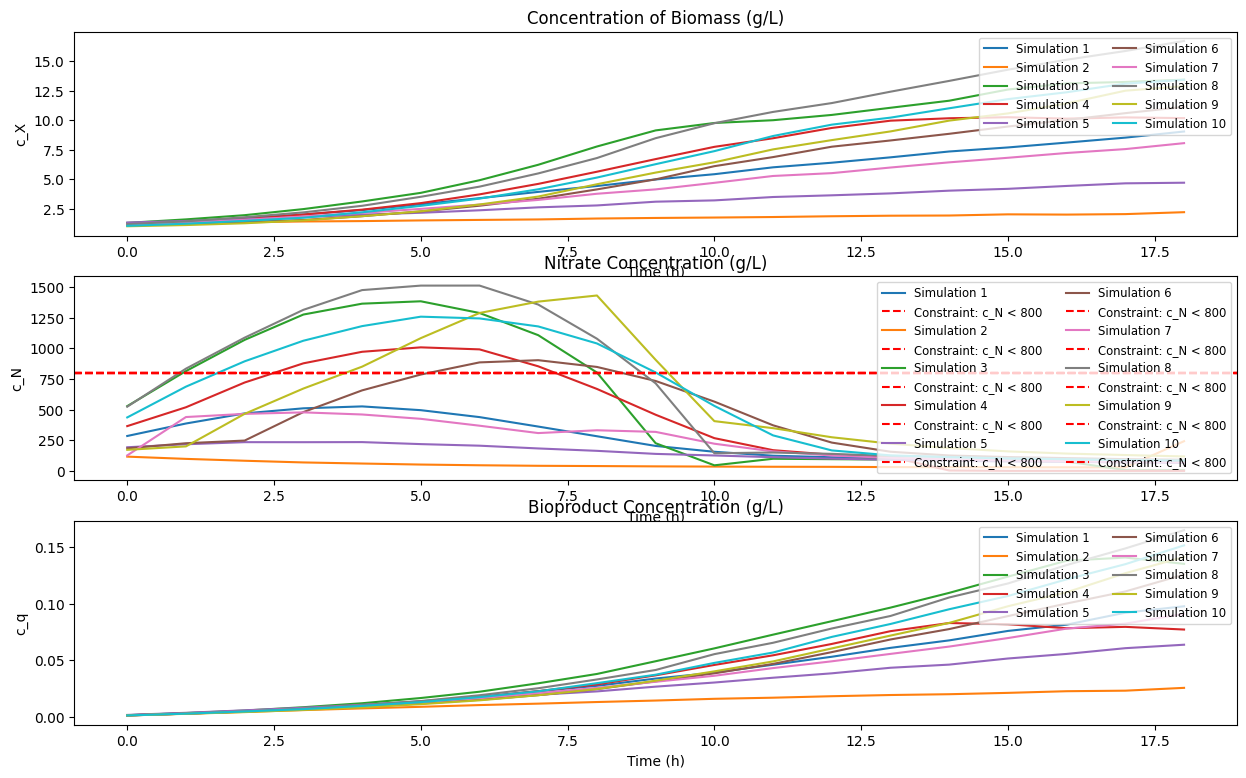

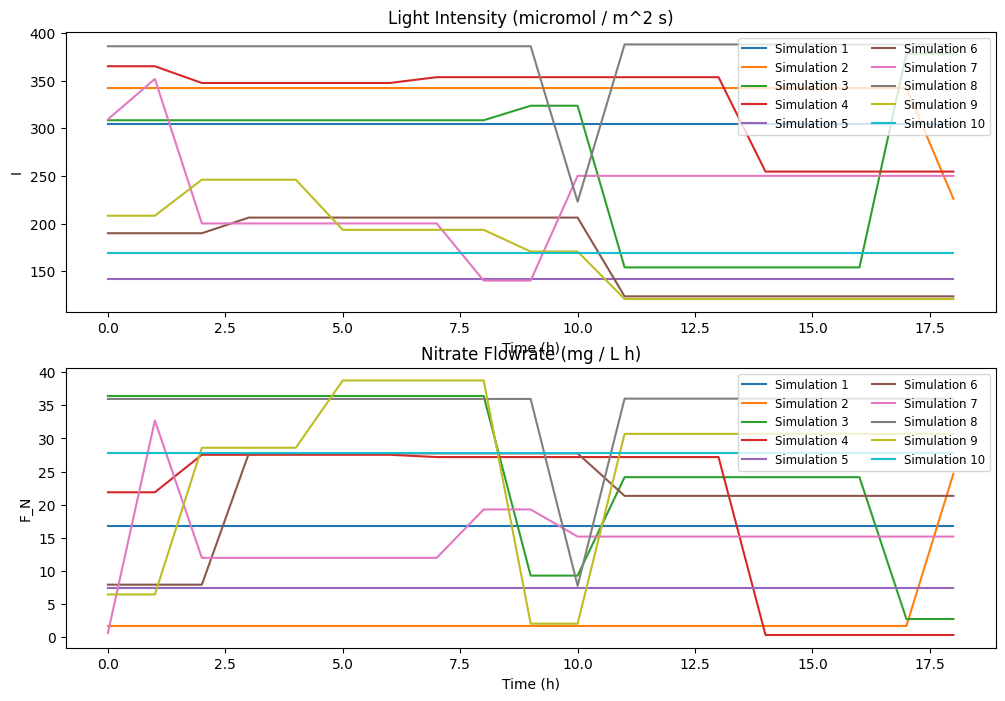

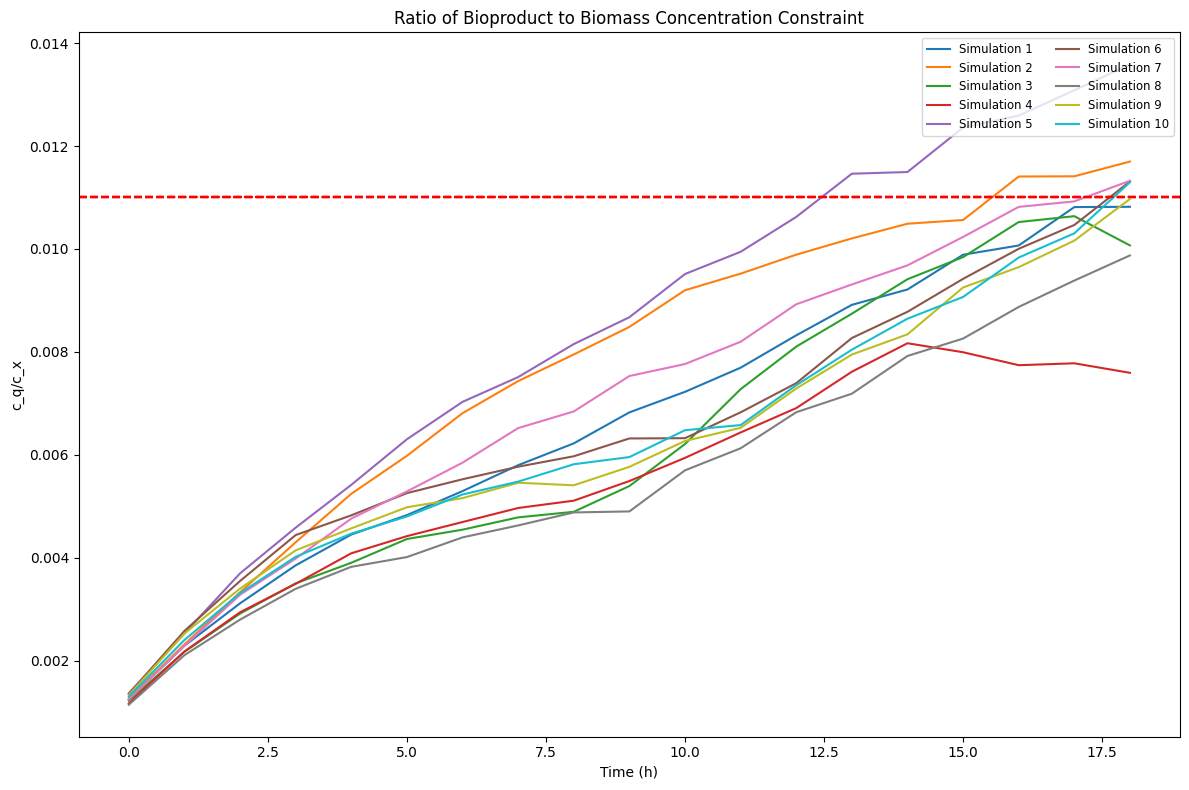

In [9]:
Bioprocess_Config = SimulationConfig(n_simulations=10, T = 20, tsim = 240) # Simulate the CSTR 10 times, with 5000 timesteps over 1000 second period

simulator = BioProcessSimulator(Bioprocess_Config)
simulation_results = simulator.run_multiple_simulations()

# Plot the output of the Simulation
simulator.plot_results(simulation_results)

In [10]:
converter = BioprocessConverter()
features, targets = converter.convert(simulation_results)

# Define a preliminary training configuration for the model
# Data processing uses an initial lookback region of 5 timesteps to predict 1 in the future 
# with an 80% train test split and a batch size of 4
training_config = TrainingConfig(
    batch_size = 4,
    num_epochs = 50,
    learning_rate = 0.001,
    time_step = 5,
    horizon = 1,
    weight_decay = 0.01,
    factor = 0.8,
    patience = 10,
    delta = 0.1,
    train_test_split = 0.8,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
)

data_processor = DataProcessor(training_config)
(train_loader, test_loader, X_train, X_test, y_train, y_test) = data_processor.prepare_data(features, targets)

Epoch [10/50], Train Loss: 0.0450, Test Loss: 0.0774, Avg Loss: 0.0612
Epoch [20/50], Train Loss: 0.0162, Test Loss: 0.0381, Avg Loss: 0.0271
Epoch [30/50], Train Loss: 0.0178, Test Loss: 0.0238, Avg Loss: 0.0208
Epoch [40/50], Train Loss: 0.0188, Test Loss: 0.0259, Avg Loss: 0.0223
Epoch [50/50], Train Loss: 0.0270, Test Loss: 0.0252, Avg Loss: 0.0261


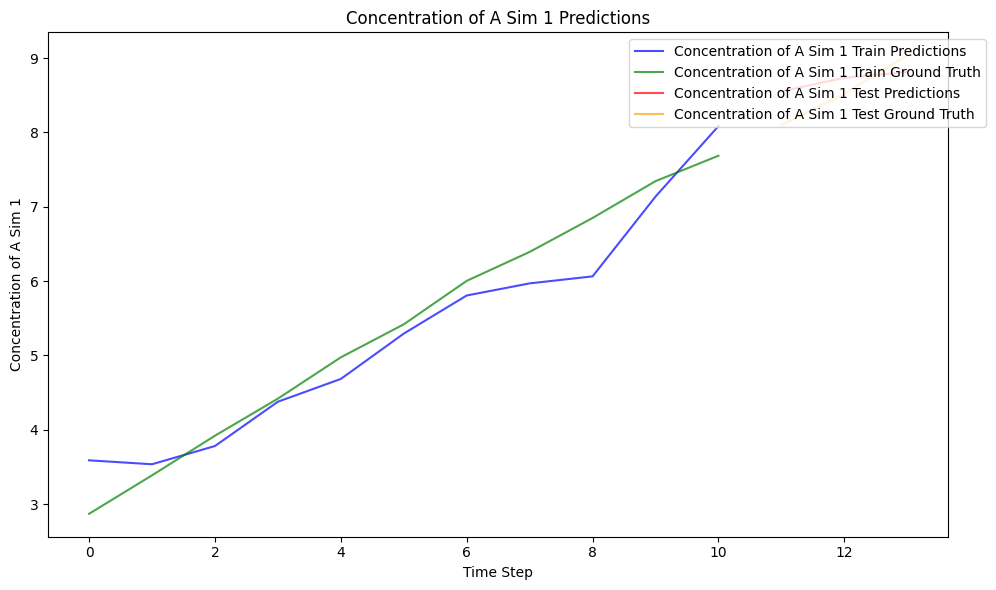

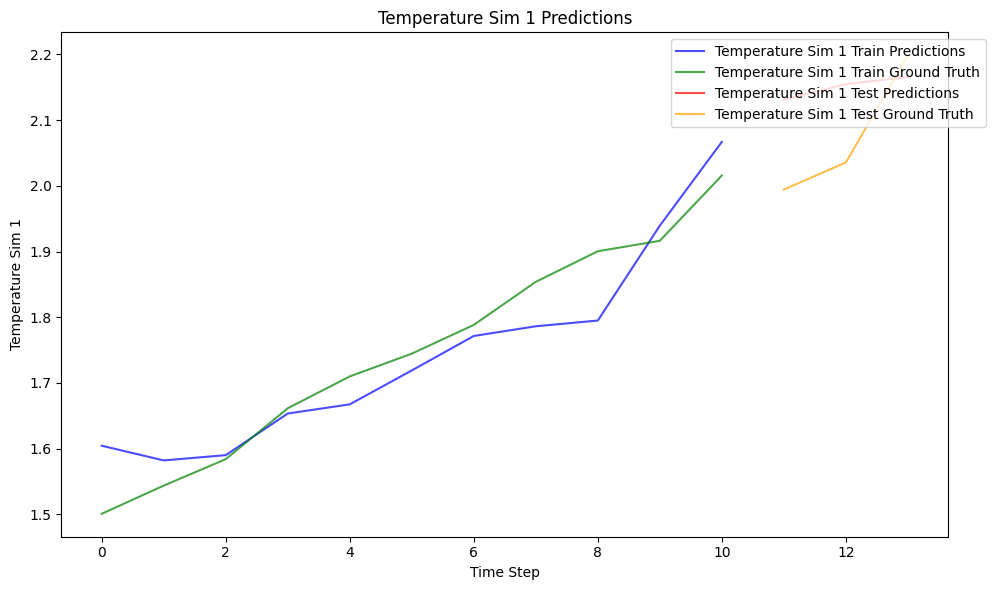

In [11]:
CNN_Config = CNNConfig(
    conv_channels = [16, 32],
    kernel_sizes = [5, 3],
    fc_dims = [101, 128],
    dropout = 0.1
    )

quantiles = [0.25, 0.5, 0.75]

model = StandardCNN(
    config = CNN_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

# Find the model predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Transform the predictions back to the original
scaler = data_processor.target_scaler
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Invert the ground truth data
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)


# Plot the results of the model
feature_names = ['Concentration of A', 'Temperature']
visualiser = Visualizer()
# For simplicity we will plot the first simulation
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=1)

### Quantifying Uncertainty in the Model Output

#### Monte Carlo Dropout
   - This is essentially a Bayesian Approximation, as this involves sampling with replacement and randomly setting the weights of the output of the model to 0
   - This is applied post training, and accounts for the aleatoric uncertainty of the model

In [12]:
CNN_Config = CNNConfig(
    conv_channels = [16, 32],
    kernel_sizes = [5, 3],
    fc_dims = [101, 128],
    dropout = 0.1
    )

model = MC_CNN(
    config = CNN_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.MSELoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: 0.0707, Test Loss: 0.0937, Avg Loss: 0.0822
Epoch [20/50], Train Loss: 0.0275, Test Loss: 0.0904, Avg Loss: 0.0590
Epoch [30/50], Train Loss: 0.0448, Test Loss: 0.0609, Avg Loss: 0.0529
Epoch [40/50], Train Loss: 0.0107, Test Loss: 0.1472, Avg Loss: 0.0790
Epoch [50/50], Train Loss: 0.0175, Test Loss: 0.1727, Avg Loss: 0.0951


In [13]:
# Initialise the Monte Carlo Predictor
mc_predictor = MC_Prediction(model, CNN_Config, num_samples = 1000)
# Pass the test data through the model, with a Monte Carlo sample size of 100
mean_train_pred, var_train_pred = mc_predictor.predict(X_train)
mean_test_pred, var_test_pred = mc_predictor.predict(X_test)

In [14]:
# Invert the training prediction
mean_train_pred, mean_test_pred = scaler.inverse_transform(mean_train_pred), scaler.inverse_transform(mean_test_pred)
var_train_pred, var_test_pred = scaler.inverse_transform(var_train_pred), scaler.inverse_transform(var_test_pred)

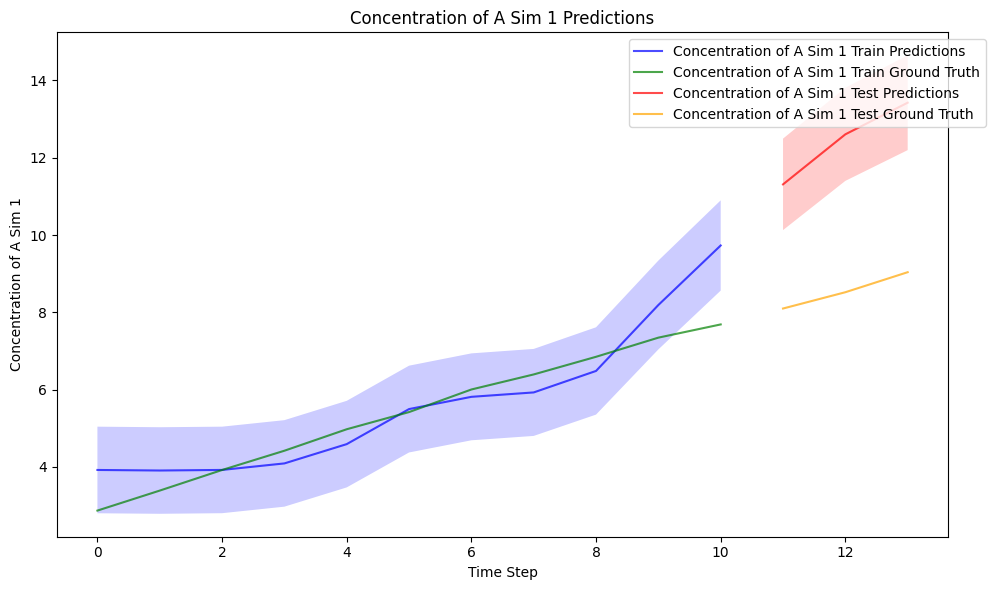

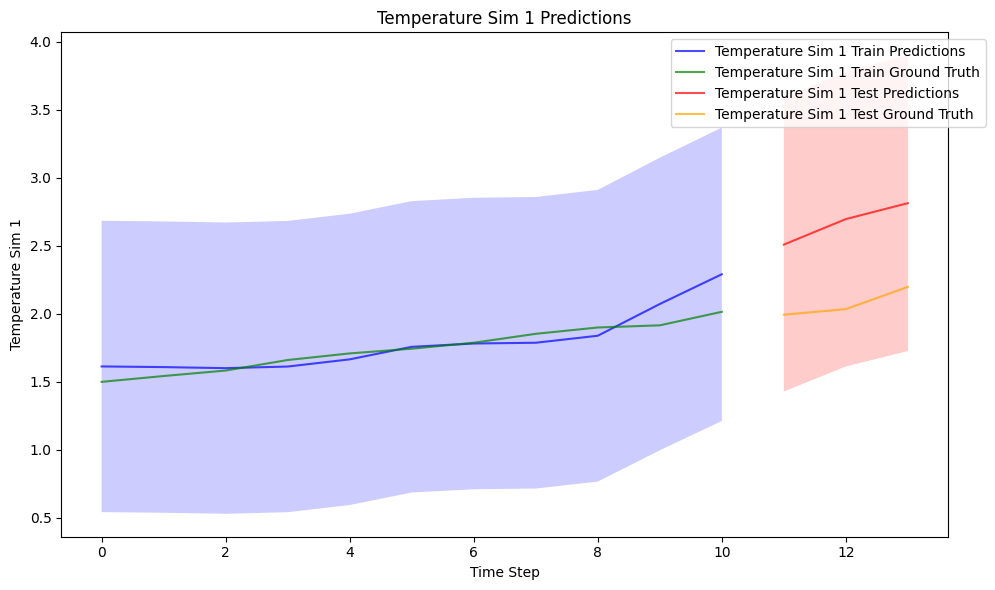

In [15]:
# Visualise the output
visualiser.plot_predictions(mean_train_pred, mean_test_pred, y_train, y_test, feature_names, num_simulations=1, train_var = var_train_pred, test_var = var_test_pred)

#### Negative Log Likelihood Loss Function
- This uses a second projection layer from the output of the network to predict the log variance of the prediction
- The output can be used to find uncertainty bounds
- The negative log likelihood assumes the output variables are normally distributed

In [16]:
CNN_Config = CNNConfig(
    conv_channels = [16, 32],
    kernel_sizes = [5, 3],
    fc_dims = [101, 128],
    dropout = 0.1
    )

model = NLL_CNN(
    config = CNN_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
)

# Train the model
criterion = nn.GaussianNLLLoss()
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: -0.4146, Test Loss: -0.5385, Avg Loss: -0.4765
Epoch [20/50], Train Loss: -1.0895, Test Loss: 0.6489, Avg Loss: -0.2203
Epoch [30/50], Train Loss: -1.3126, Test Loss: 17.2736, Avg Loss: 7.9805
Epoch [40/50], Train Loss: -1.1302, Test Loss: 1.2731, Avg Loss: 0.0715
Epoch [50/50], Train Loss: -1.4175, Test Loss: 14.9200, Avg Loss: 6.7512


In [17]:
# The NLL CNN model outputs the mean and variance of the prediction
model.eval()
with torch.no_grad():
    train_pred, train_var = model(X_train.to(training_config.device))
    test_pred, test_var = model(X_test.to(training_config.device))
    
# Invert the predictions    
train_pred, test_pred = scaler.inverse_transform(train_pred.cpu().numpy()), scaler.inverse_transform(test_pred.cpu().numpy())
train_var, test_var = scaler.inverse_transform(train_var.cpu().numpy()), scaler.inverse_transform(test_var.cpu().numpy())

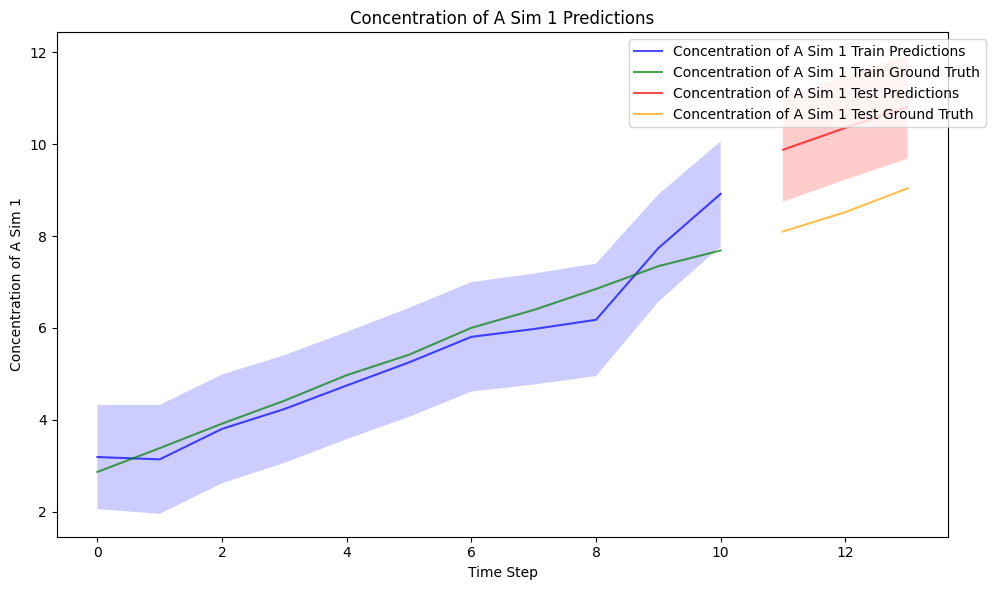

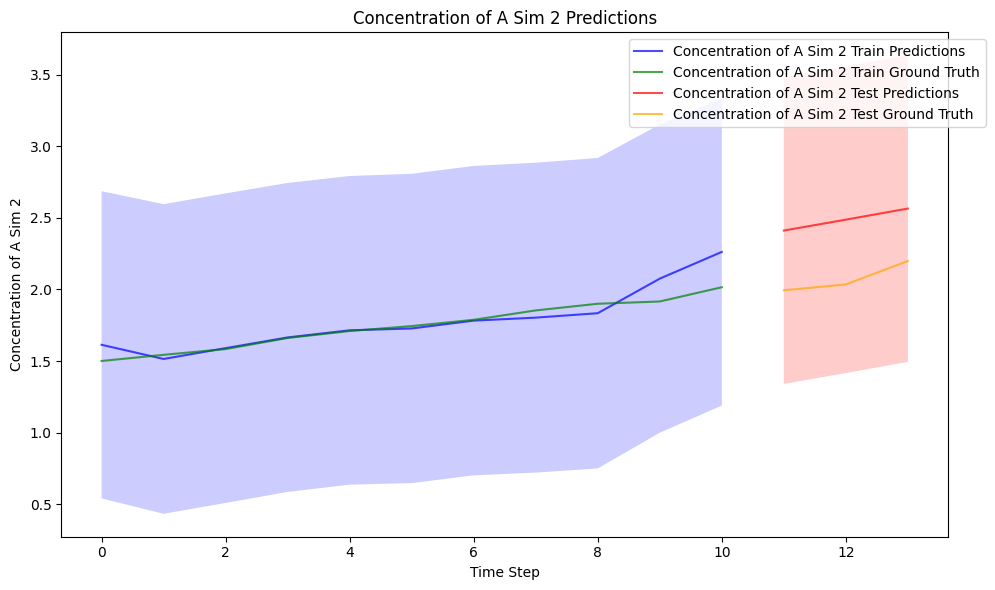

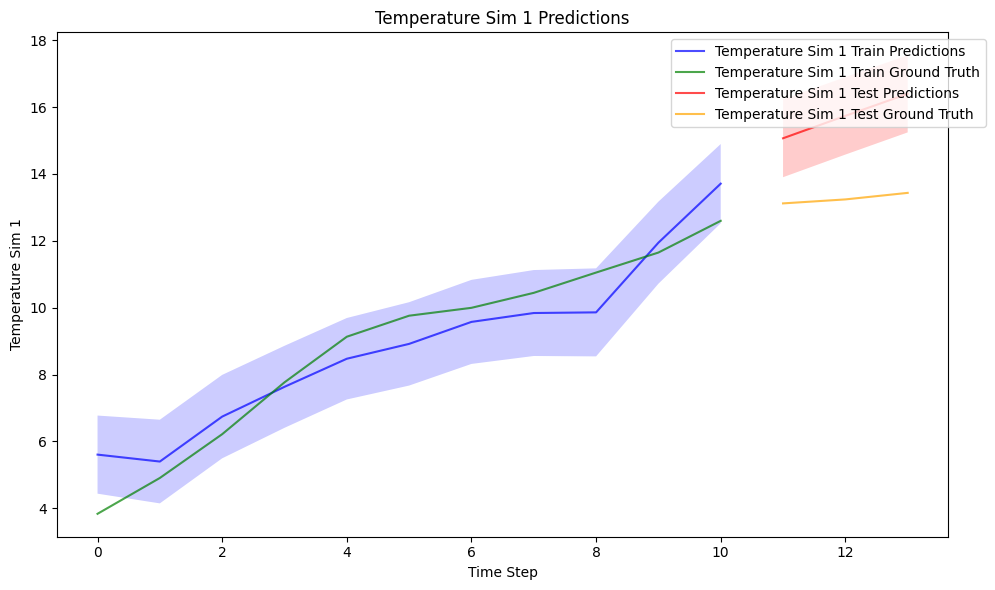

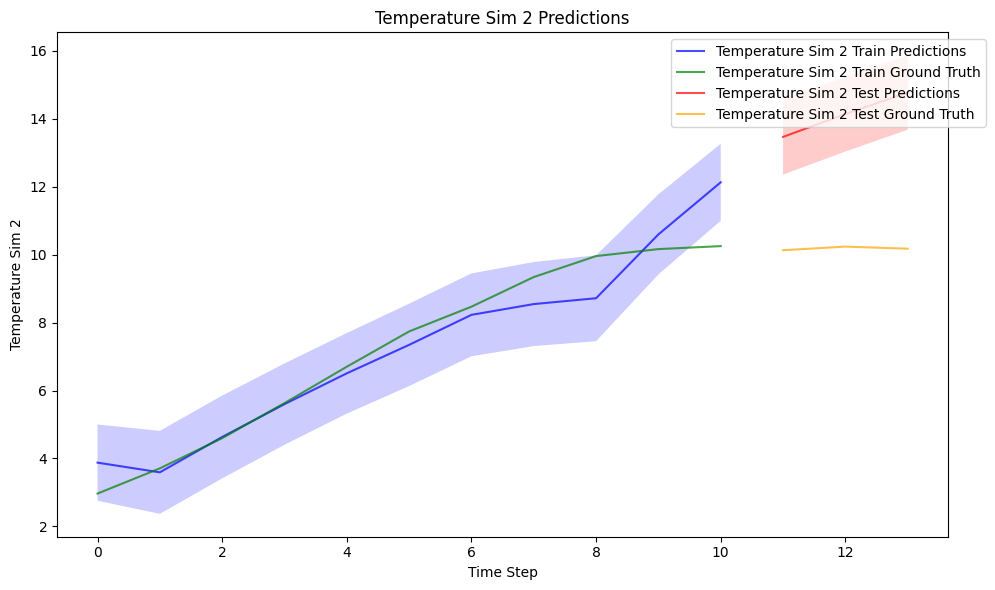

In [18]:
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=2, train_var = train_var, test_var = test_var)

#### Quantile Regression
- Quantile Regression uses a pinball loss function to account for the 'quantile' the each prediction should lie above
- The median quantile reverts back to the MSE Loss Function
- Distribution free method

In [19]:
CNN_Config = CNNConfig(
    conv_channels = [16, 32],
    kernel_sizes = [5, 3],
    fc_dims = [101, 128],
    dropout = 0.1
    )

# Train the model on the 25th, 50th and 75th quantiles
quantiles = [0.25, 0.5, 0.75]

model = QuantileCNN(
    config = CNN_Config,
    input_dim = X_train.shape[2],
    output_dim = y_train.shape[1],
    quantiles = quantiles
)

# Train the model
criterion = QuantileLoss(quantiles)
trainer = ModelTrainer(model, training_config)
model, history, avg_loss = trainer.train(train_loader, test_loader, criterion)

Epoch [10/50], Train Loss: 0.1714, Test Loss: 0.2703, Avg Loss: 0.2209
Epoch [20/50], Train Loss: 0.0889, Test Loss: 0.1310, Avg Loss: 0.1100
Epoch [30/50], Train Loss: 0.0650, Test Loss: 0.0798, Avg Loss: 0.0724
Epoch [40/50], Train Loss: 0.0808, Test Loss: 0.0708, Avg Loss: 0.0758
Epoch [50/50], Train Loss: 0.0671, Test Loss: 0.0522, Avg Loss: 0.0596


In [20]:
# Get the output of the model

model.eval()
with torch.no_grad():
    train_pred = model(X_train.to(training_config.device)).cpu().numpy()
    test_pred = model(X_test.to(training_config.device)).cpu().numpy()

# Invert the output of the model
inverse_transformer = QuantileTransform(quantiles, scaler)
train_pred = inverse_transformer.inverse_transform(train_pred)
test_pred = inverse_transformer.inverse_transform(test_pred)

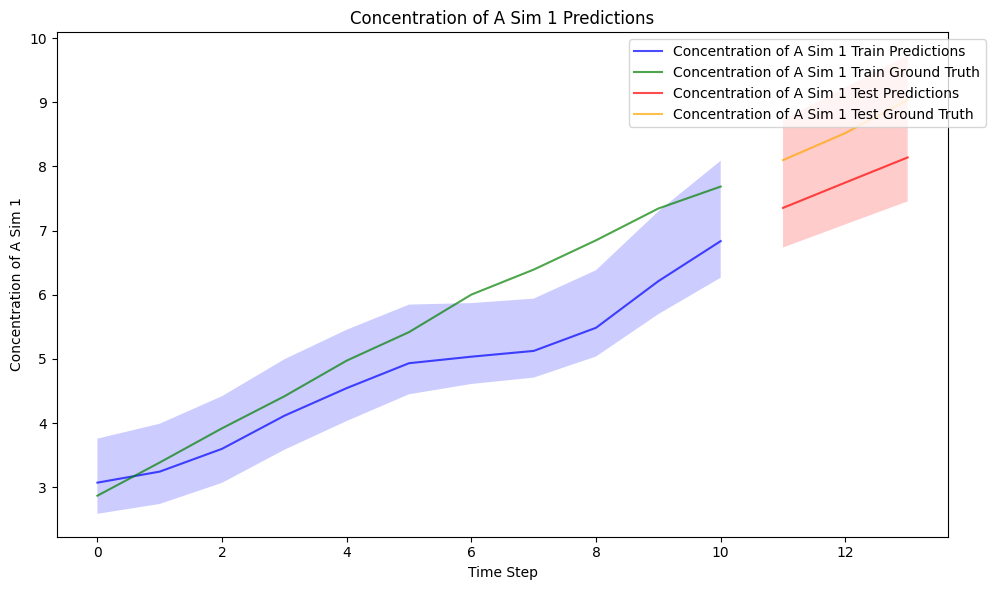

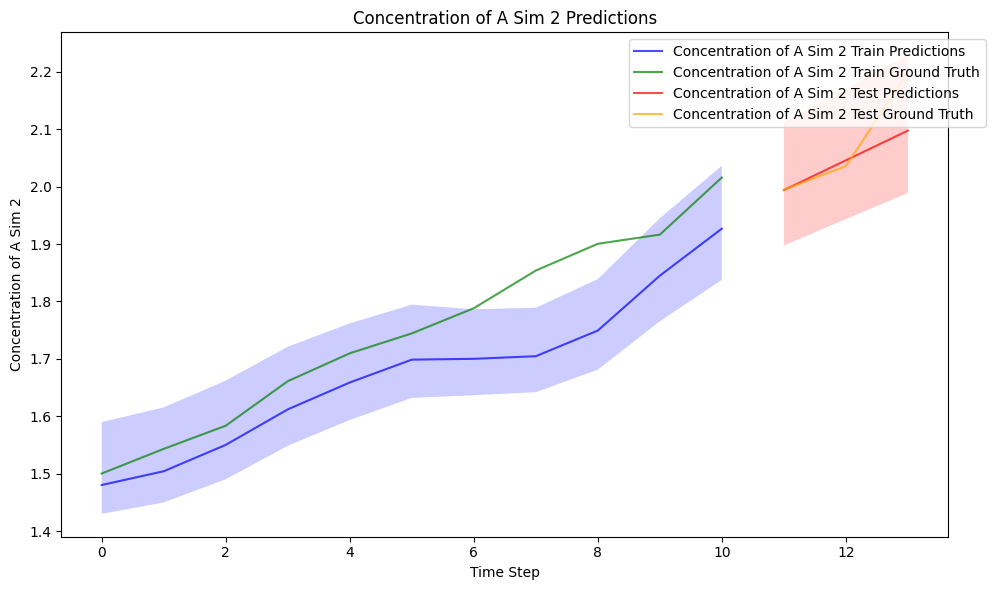

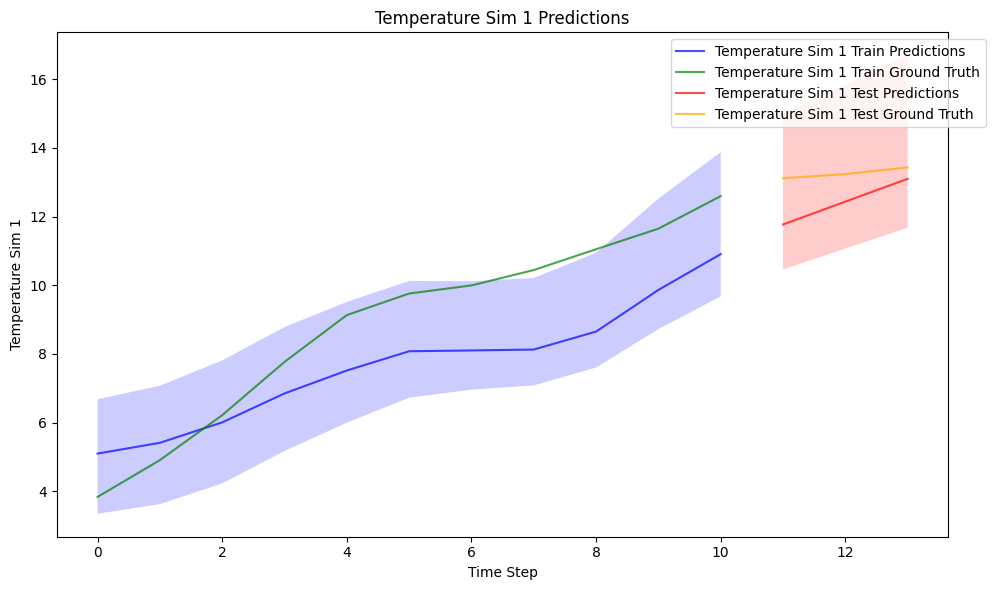

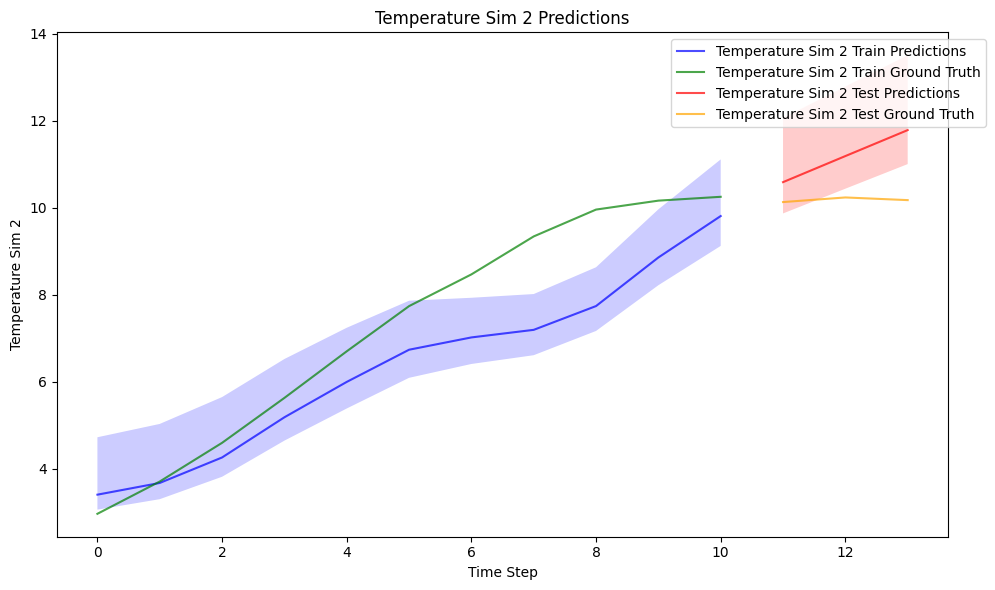

In [21]:
visualiser.plot_predictions(train_pred, test_pred, y_train, y_test, feature_names, num_simulations=2)

Quantile regression offers no guarantees that a certain quantile will contain a certain amount of the data-points, hence is tough to provide an exact confidence level.
Conformal prediction uses the test set to calculate the residuals, assign a score and then after sorting the residuals, can calibrate a distribution free confidence bound.

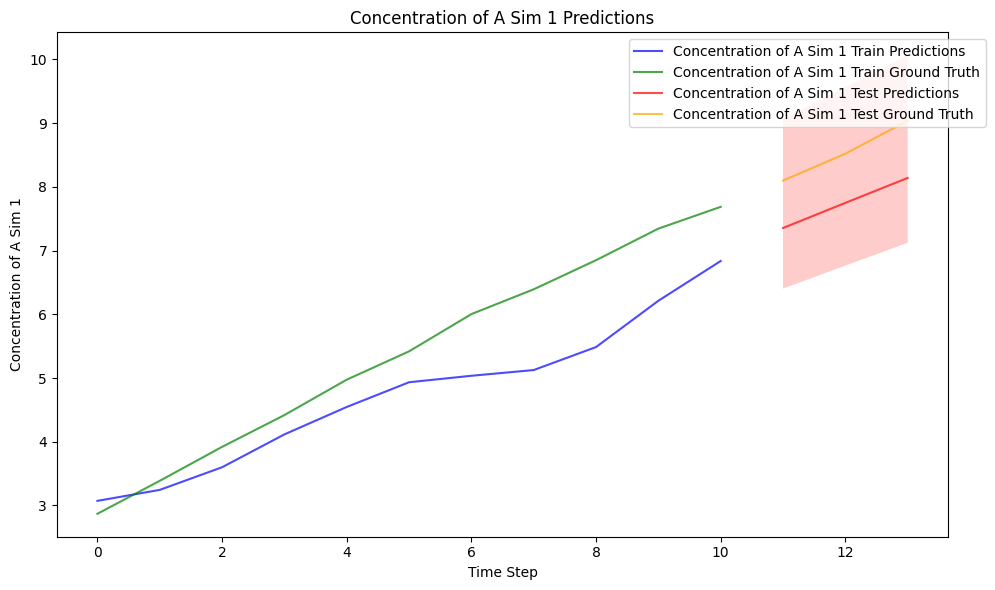

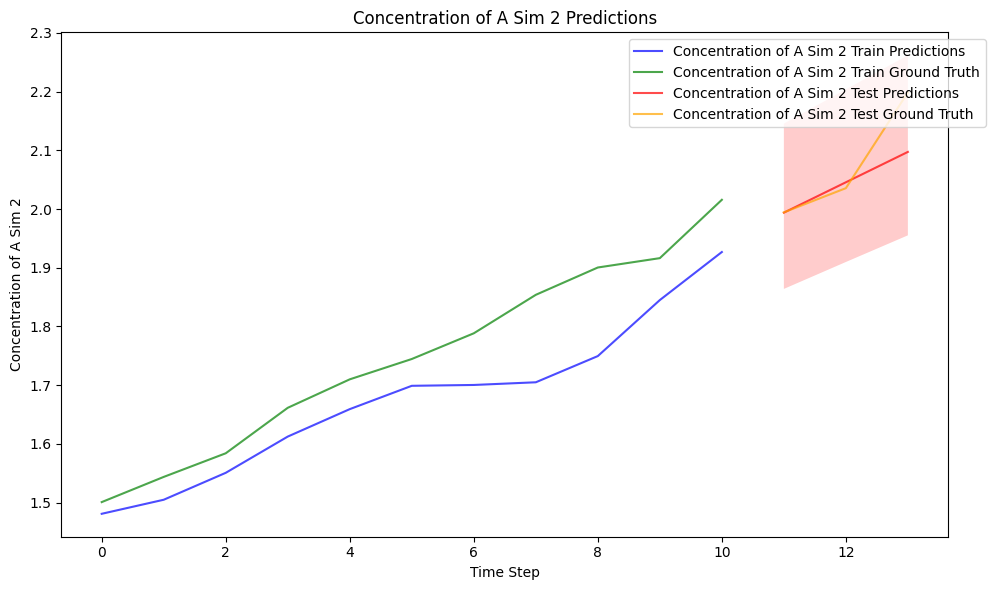

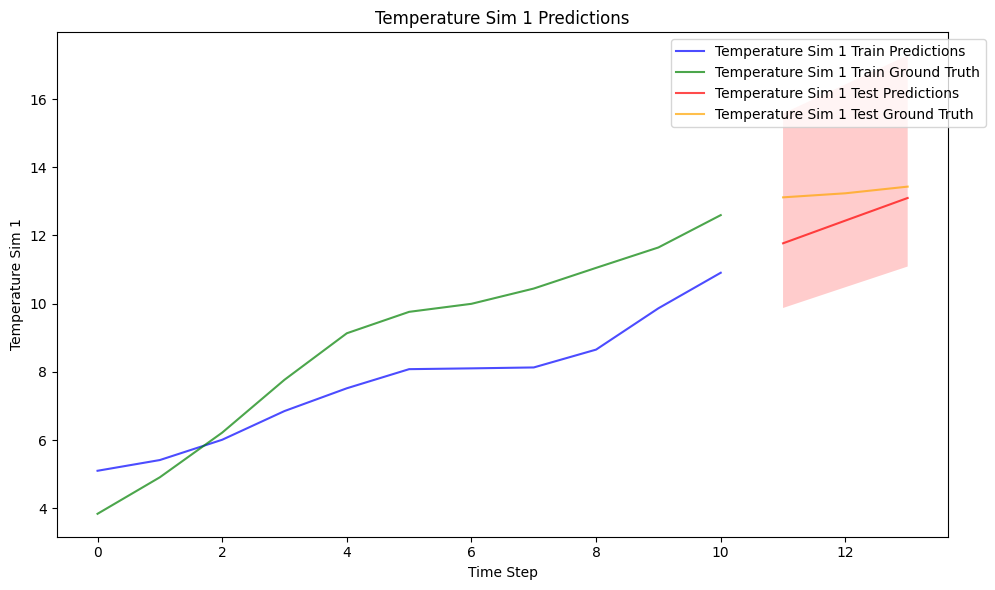

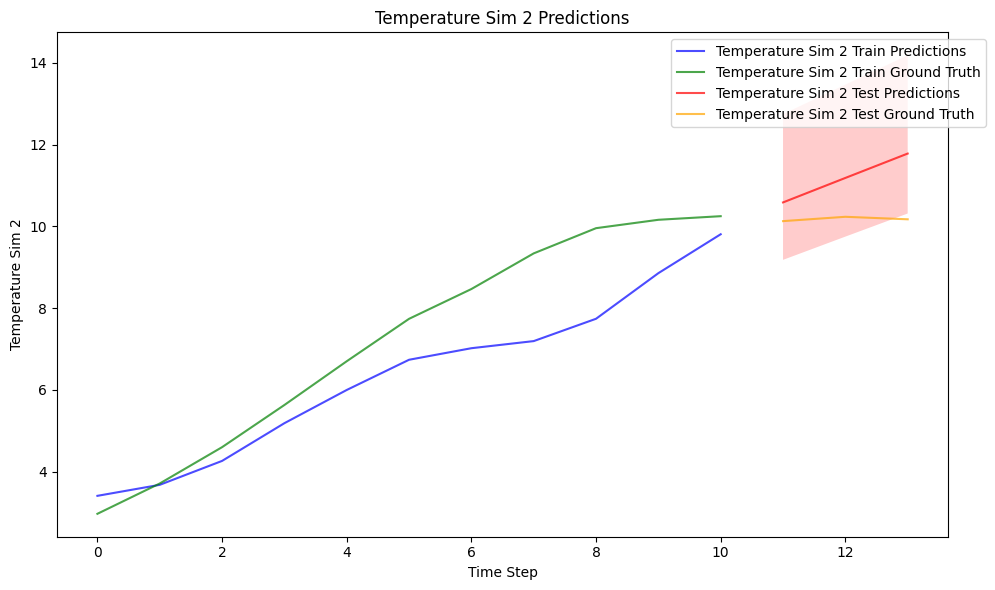

In [22]:
conformal = ConformalQuantile(model, inverse_transformer, alpha = 0.10) # Alpha is the parameter to bound the confidence interval - e.g. 0.1 = 90% confidence
conformal.fit_calibrate(X_test, y_test, method='absolute')
results = conformal.predict(X_test, y_test, method = 'absolute') # Calculates the absolute residuals 

# Results is a dictionary containing the 90% confidence bounds, and also the equivalent quantile corresponding to the desired confidence level
# e.g. the 90% confidence could be found between the 25th and 75th quantile

visualiser.plot_conformal(train_pred[0.5], test_pred[0.5], y_train, y_test, results, feature_names, num_simulations=2)